# 3.7. Weight Decay

Sometimes we can limit our model's capacity by tweaking the degree of the fitted polynomial. Indeed, limiting the number of features is a popular technique to mitigate overfitting. however, simply tossing aside features can be too blunt an instrument. 

## 3.7.1. Norms and Weight Decay

Rather than directly manipulating the number of parameters, __weight decay__, __operates by restricting the values that the parameters can take__. More commonly called _l2 regularoization_ outside of deep learning circles when optimized by minibatch stochastic gradient descent, __weight decay__ might be the most widely used technique for regularizing parametric machine learning models. 

### What is the point of restricting the values the parameters of a function can take? Cui Bono?

The technique is motivated by the basic intuition that among all functions _f_ , the function _f_ = 0 (assigning the value 0 to all inputs) is in some sense the simplest, and that we can measure the complexity of a function by the distance of its parameters from zero. 

### But how precisely should we measure the distance between a function and zero? 

There’s no single right answer. In fact, entire branches of mathematics, including parts of functional analysis and the theory of Banach spaces, are devoted to addressing such issues.

### Weight Decay (in other words):

The behaviour of our algorithm is strongly affected not just by how large we make the set of functions allowed in its _hypothesis space_, but (also) by the specific identity of those functions. (To be continued) 

The most common method for ensuring a small weight vector is to __add its norm as a penalty term to the problem of minimizing the loss__. Thus we replace our original objective, _minimizing the prediction loss on the training labels_, with new objective, _minimizing the sum of the prediction loss and the penalty term_. 

## 3.7.2. High-Dimensional Linear Regression

Demostrating the benefits of weight decay through a simple synthetic example. 

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

First we generate a synthetic dataset. In this synthetic dataset, our label is given by an underlying linear function of our inputs, corrupted by Gaussian noise with zero mean and standard deviation 0.01. For illustrative purposes, we can make the effects of overfitting pronounced, by increasing the dimensionality of our problem to d = 200 and working with a small training set with only 20 examples. 

In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

## 3.7.3. Implementation from Scratch

Now, let's try implementing weight decay from scratch. Since minibatch stochastic gradient descent is our optimizer, we just need to add the squared l2 penalty to the original loss function. 

In [3]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### 3.7.3.2. Defining the Model 

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * l2_penalty(self.w)

The following code fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.

In [5]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

## 3.7.3.3 Training Without Regularization

We now run this code with lambd = 0, disabling weight decay. Note that we overfit badly, decreasing the training error but not the validation error—a textbook case of overfitting.

L2 norm of w: 0.010581585578620434


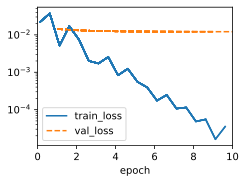

In [6]:
train_scratch(0)

## 3.7.3.4 Using Weight Decay

Below, we run with substantial weight decay. Note that the training error increases but the validation error decreases. This is precisely the effect we expect from regularization.

L2 norm of w: 0.0014802890364080667


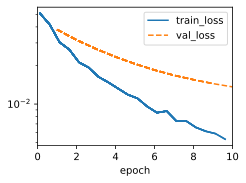

In [7]:
train_scratch(3)

## 3.7.4. Concise Implementation

Because weight decay is ubiquitous in neural network optimization, the deep learning framework makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, the optimizer must touch each parameter once anyway.

In the following code, we specify the weight decay hyperparameter directly through weight_decay when instantiating our optimizer. By default, PyTorch decays both weights and biases simultaneously. Here, we only set weight_decay for the weight, so the bias parameter  will not decay.

In [8]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
    
    
    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

The plot looks similar to that when we implemented weight decay from scratch. However, this version runs faster and is easier to implement, benefits that will become more pronounced as you address larger problems and this work becomes more routine.

L2 norm of w: 0.01364334300160408


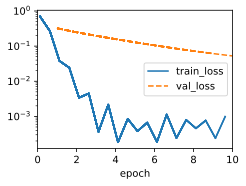

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

__Regularization:__ is any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error.

Regularization is one of the central concerns of the fieldd of machine learning, rivaled in its importance only by optimization.

The no free lunch theorem has made it clear that there is no best machine learning algorithm, and, in particular, no best from of regularization